In [1]:
pip install reedsolo

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
berr=[]
K = 64 # number of OFDM subcarriersv
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 10 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.
# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
print(pilotCarriers)
P = P+1
# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
#16QAM
mu =  4# bits per symbol (i.e. 16QAM)
mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

[ 0  6 12 18 24 30 36 42 48 54 60 63]


In [134]:

demapping_table = {v : k for k, v in mapping_table.items()}
channelResponse = np.array([1, 0, 0.1+0.1j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)

Reed Solomon

In [4]:
n = 15
k = 11
import numpy as np
from reedsolo import RSCodec, ReedSolomonError

def binary_to_symbols(binary):
    """ Convert a binary list to a list of integers (Galois field symbols). """
    byte_length = len(binary) // 8  # Calculate how many bytes
    symbols = [int("".join(map(str, binary[i*8:(i+1)*8])), 2) for i in range(byte_length)]
    return symbols

def symbols_to_binary(symbols):
    """ Convert a list of Galois field symbols back to a binary list. """
    binary = []
    for symbol in symbols:
        bin_repr = list(map(int, f"{symbol:08b}"))
        binary.extend(bin_repr)
    return binary
def encode_message(original_bits):
    """Encode a list of bytes using Reed-Solomon coding."""
    rsc = RSCodec(4)  # 4 parity bytes
    # Encode the original data
    original_bytes = binary_to_symbols(original_bits)
    encoded_bytes = rsc.encode(original_bytes)
    return np.array(list(encoded_bytes), dtype=np.uint8)


bits=np.random.binomial(n=1, p=0.5, size=(13728*30, ))
coded_symbols=[]

# get 11 byte and give 15 symbols
for i in range(0,len(bits),88):
  raw_binary_input=bits[i:i+88]
  # Convert binary input to symbols
  encoded_message = encode_message(raw_binary_input)
  coded_symbols.append(encoded_message)

In [5]:
combined_array = np.concatenate(coded_symbols)
combined_list = combined_array.tolist()

In [6]:
#combined_list is coded symbols
def symbols_to_binary(symbols):
    """ Convert a list of Galois field symbols back to a binary list. """
    binary = []
    for symbol in symbols:
        bin_repr = list(map(int, f"{symbol:08b}"))  # Convert each symbol to binary
        binary.extend(bin_repr)
    return binary
#after coding befor modulation
coded_bits=symbols_to_binary(combined_list)

In [7]:
#serial to parallel
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise
def removeCP(signal):
    return signal[CP:(CP+K)]
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

In [8]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)

    return Hest

def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
def get_payload(equalized):
    return equalized[dataCarriers]
def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])

    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))

    # for each element in QAM, choose the index in constellation
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)

    # get back the real constellation point
    hardDecision = constellation[const_index]

    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision
def PS(bits):
    return bits.reshape((-1,))

def binary_to_symbols(binary):
    """ Convert a binary list to a list of integers (Galois field symbols). """
    byte_length = len(binary) // 8  # Calculate how many bytes
    symbols = [int("".join(map(str, binary[i*8:(i+1)*8])), 2) for i in range(byte_length)]
    return symbols

In [ ]:
coded_bits=np.array(coded_bits)

In [70]:
#calculations for one SNR
# SNRdb=15
# QAM_est=[]
# for i in range(0,len(coded_bits),payloadBits_per_OFDM):
#   ofdm_sym=coded_bits[i:i+payloadBits_per_OFDM]
#   #print(len(ofdm_sym))
#   bits_SP = SP(ofdm_sym)
#   QAM = Mapping(bits_SP)
#   OFDM_data = OFDM_symbol(QAM)
#   OFDM_time = IDFT(OFDM_data)
#   OFDM_withCP = addCP(OFDM_time)
#   OFDM_TX = OFDM_withCP
#   #channel
#   OFDM_RX = channel(OFDM_TX)
#   #receiver
#   OFDM_RX_noCP = removeCP(OFDM_RX)
#   OFDM_demod = DFT(OFDM_RX_noCP)
#   Hest = channelEstimate(OFDM_demod)
#   equalized_Hest = equalize(OFDM_demod, Hest)
#   QAM_est.append(get_payload(equalized_Hest))
# combined_arr = np.concatenate(QAM_est)
# QAM_est= combined_arr.tolist()
# QAM_est=np.array(QAM_est)
#PS_est, hardDecision = Demapping(QAM_est)
#pre_decod_bits_est = PS(PS_est)
# received_sym=binary_to_symbols(pre_decod_bits_est)

In [75]:
def channel(signal, SNRdb):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

In [76]:

np.savetxt('bits.csv',bits,delimiter=',')
for SNRdb in np.arange(0, 15, 1):
  QAM_est=[]
  for i in range(0,len(coded_bits),payloadBits_per_OFDM):

    ofdm_sym=coded_bits[i:i+payloadBits_per_OFDM]
    bits_SP = SP(ofdm_sym)
    QAM = Mapping(bits_SP)
    OFDM_data = OFDM_symbol(QAM)
    OFDM_time = IDFT(OFDM_data)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
    OFDM_RX=channel(OFDM_TX,SNRdb)
    OFDM_RX_noCP = removeCP(OFDM_RX)
    OFDM_demod = DFT(OFDM_RX_noCP)
    Hest = channelEstimate(OFDM_demod)
    equalized_Hest = equalize(OFDM_demod, Hest)
    QAM_est.append(get_payload(equalized_Hest))
  combined_arr = np.concatenate(QAM_est)
  QAM_est= combined_arr.tolist()
  QAM_est=np.array(QAM_est)
  PS_est, hardDecision = Demapping(QAM_est)
  pre_decod_bits_est = PS(PS_est)
  received_sym=binary_to_symbols(pre_decod_bits_est)
  received_sym_filename = f'received_sym{SNRdb}.csv'

    # Save to CSV
  np.savetxt(received_sym_filename, received_sym, delimiter=',')


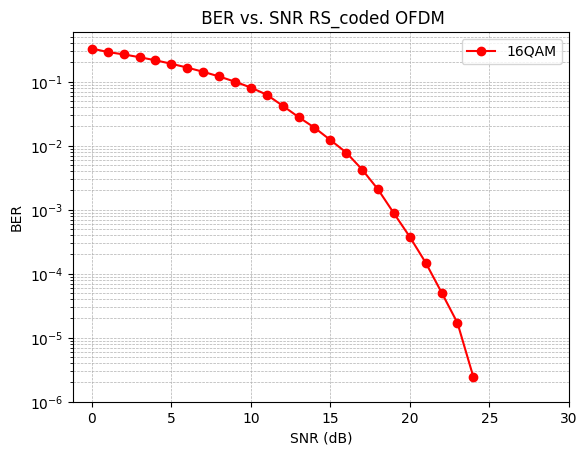

In [2]:
#bring the output of the matlab
ber=np.array([3.30000000e-01, 2.91000000e-01, 2.67412102e-01, 2.41588967e-01,
       2.16326729e-01, 1.90882382e-01, 1.66300019e-01, 1.43043415e-01,
       1.21044580e-01, 1.00131119e-01, 8.11917249e-02, 6.27088190e-02,
       4.22341686e-02, 2.80550000e-02, 1.91764763e-02, 1.23075321e-02,
       7.83429487e-03, 4.25064103e-03, 2.07921523e-03, 8.79766900e-04,
       3.76459207e-04, 1.48602009e-04, 5.08469308e-05, 1.69968920e-05,
       2.42812743e-06])
# Given SNR values and corresponding BER values
SNRdb = np.arange(0, 25, 1)  # SNR from 0 to 32 in steps of 2
ber1=ber

# Create a semilogy plot
# plt.figure(figsize=(9, 6))
# SNRdb1 = np.arange(0, 25, 1)
# plt.semilogy(SNRdb, ber, marker='o', linestyle='-', color='b')
plt.semilogy(SNRdb, ber1, marker='o', linestyle='-', color='r')
plt.title(' BER vs. SNR RS_coded OFDM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend(['16QAM'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks([0,5,10,15,20,25,30])  # Set x-ticks to the SNR values
plt.ylim(bottom=1e-6)  # Set a lower limit for the y-axis to enhance visibility
plt.show()

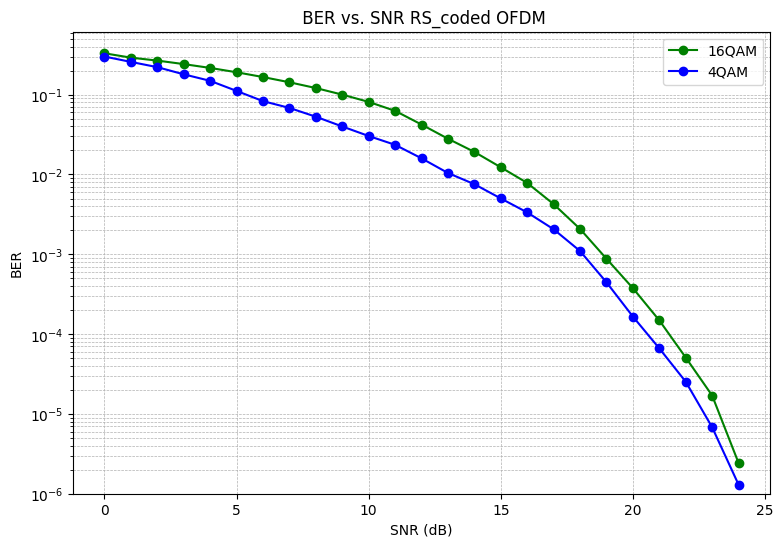

In [34]:
#FOR QPSK
mu=2
mapping_table = {
    (0,0) : 0+0*1j,
    (0,1) : np.cos(np.pi/2)+np.sin(np.pi/2)*1j,
    (1,0) : np.cos(np.pi)+np.sin(np.pi)*1j,
    (1,1) : np.cos(3*np.pi/2)+np.sin(3*np.pi/2)*1j,
}

#payloadBits_per_OFDM = len(dataCarriers)*mu
demapping_table = {v : k for k, v in mapping_table.items()}
#bring the output of the matlab
ber2=np.array([3.004570e-01, 2.57300000e-01, 2.21223631e-01, 1.79888792e-01,
       1.49056915e-01, 1.11427982e-01, 8.29782439e-02, 6.82130435e-02,
       5.29475240e-02, 3.99497815e-02, 3.03476486e-02, 2.35318182e-02,
       1.59411325e-02, 1.04399169e-02, 7.55844289e-03, 5.00990726e-03,
       3.34759599e-03, 2.05862180e-03, 1.09882867e-03, 4.45722222e-04,
       1.65914452e-04, 6.62265234e-05, 2.53140993e-05, 6.80291453e-06,
       1.29899717e-06])
# Given SNR values and corresponding BER values
SNRdb = np.arange(0, 25, 1)  # SNR from 0 to 32 in steps of 2

# Create a semilogy plot
plt.figure(figsize=(9, 6))
plt.semilogy(SNRdb, ber1, marker='o', linestyle='-', color='g')
plt.semilogy(SNRdb, ber2, marker='o', linestyle='-', color='b')
plt.title(' BER vs. SNR RS_coded OFDM')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend(['16QAM','4QAM'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks([0,5,10,15,20,25])  # Set x-ticks to the SNR values
plt.ylim(bottom=1e-6)  # Set a lower limit for the y-axis to enhance visibility
plt.show()